# Parameter Optimisation With TA-lib
## Part 1

In [101]:
"""
MSFT works really well after 2013. polarity=1
ORCL works well the whole time. Polarity is (i think) = -1
XOM is not so great.
IBM has a negative IS/OOS correlation
AMZN great performance but not so good IS/OOS corr because it's split into several sections
AAPL pretty good
ABT pretty good
GS not so good
SPY Good
"""

"\nMSFT works really well after 2013. polarity=1\nORCL works well the whole time. Polarity is (i think) = -1\nXOM is not so great.\nIBM has a negative IS/OOS correlation\nAMZN great performance but not so good IS/OOS corr because it's split into several sections\nAAPL pretty good\nABT pretty good\nGS not so good\nSPY Good\n"

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import talib
import yfinance as yf
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [103]:
stocks = ['MSFT','AMZN','XOM','ORCL','IBM','AAPL','ABT','GS','SPY','BRK']

In [104]:
" ".join(stocks)

'MSFT AMZN XOM ORCL IBM AAPL ABT GS SPY BRK'

In [105]:
data = yf.download(tickers = " ".join(stocks),
        period = "20y",
        #end = "2020-07-05",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = False,
        prepost = False,
        threads = True,
        proxy = None
    )


[*********************100%***********************]  10 of 10 completed


In [106]:
data['AMZN'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-07,16.110001,16.350000,16.030001,16.110001,16.110001,5543700
2002-05-08,16.549999,17.459999,16.500000,17.320000,17.320000,7888400
2002-05-09,17.120001,18.230000,17.100000,17.730000,17.730000,11002300
2002-05-10,17.889999,17.959999,16.799999,16.940001,16.940001,7572800
2002-05-13,17.170000,17.629999,16.850000,17.320000,17.320000,6700100


In [107]:
def backtest(sym,p1,p2,polarity = 1):
    """
    Backtester for MA-crossover
    Inputs:
        sym: stock symbol
        p: parameters
        
    Output:
        unrlzd: unrealizd PnL
    """
    
    d = data[sym]['Adj Close']
    sma1 = talib.SMA(np.asarray(d),min([p1,p2]))
    sma2 = talib.SMA(np.asarray(d),max([p1,p2]))
    sma_diff = sma1-sma2 # + + + - olduğu anda 60ma>20ma olmuştur, short açmalıyız (side=-1 olmalı)
                        # ---+ olduğu anda 20ma>60ma olmuştur. long (side=+1)
    
    unrlzd = []
    side = 0
    for i in range(500,len(d)):
        unrlzd.append((d[i]-d[i-1])/d[i-1]*side) # fiyat düşüyor, d[i-1] > d[i], side -1 ile çarpıldığı için shortta PnL + yazıyor
                                                # fiyat artıyor, d[i] > d[i-1], side +1, pnl + yazar
        if np.sign(sma_diff[i])!=np.sign(sma_diff[i-1]):
            side = np.sign(sma_diff[i])*polarity
            #side = -1 * (+) olması lazım ki side - olsun ama aşağıda polarity -1 yapmış (???)
            #side = +1 * (+) olması lazım ki side + olsun... aynı sorun yine var

    return unrlzd

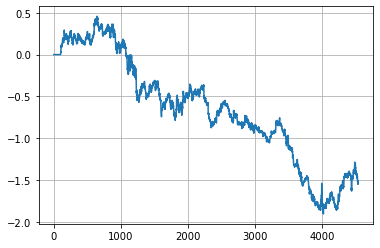

In [108]:
pnl_hch = backtest('ORCL', 20, 60)
plt.plot(np.cumsum(pnl_hch))
plt.grid()

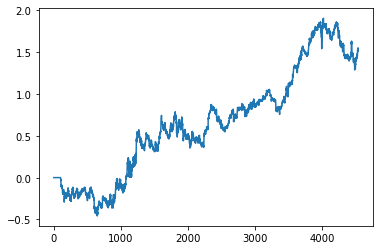

In [109]:
pnl = backtest('ORCL',20,60, polarity=-1)
plt.plot(np.cumsum(pnl))

Text(0, 0.5, 'Lookback 2')

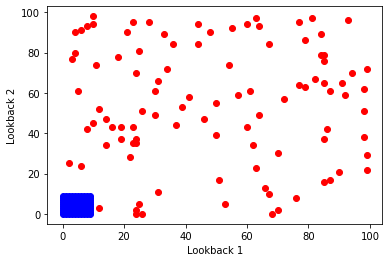

In [110]:
for i in range(10):
    for k in range(10):
        plt.plot(i,k,'bo')
        
plt.plot(np.random.randint(0,100,100),np.random.randint(0,100,100),'ro')
plt.xlabel('Lookback 1')
plt.ylabel('Lookback 2')

In [111]:
def sweep(r,stocks,N=100,res=[],unall=[]):
    """
    Parameters sweep for backtester.
    
    Inputs: 
        r: Nx2 array of parameters
        stocks: list of stock symbols
        N: number of samples
        
    Outputs:
        res: NxM matrix of N simulations with parameters and result
    """
    
    for i in range(N):
        if r[i,0]==r[i,1]: continue # iki randnum da eşitse boşgeç
        all_pnls = [] # her yeni loopta sıfırlanması için burada
        for stock in stocks:    # functiona verdiğimiz her stock için backtest yapsın, numparı da all_pnls'e atsın
            unrlzd = backtest(stock,int(r[i,0]),int(r[i,1]),polarity = -1) 
            # büyük ihtimalle bu mal da neden kötü sonuç çıktığını anlamadı ve polarity -1 kullandı
            all_pnls.append(unrlzd)
            # entry-exitler reelde eşzamanlı ama bu for loop eşzamanlı yapmadığı için tam doğru sonucu vermeyecektir.

        portf_ret = np.mean(np.array(all_pnls),axis=0) 
        # buna göre kar edersek çekiyoruz, zarar edersek ekliyoruz VEYA her stock kendi eşit parasında dönüyor
        S = np.mean(portf_ret)/np.std(portf_ret)*16 # 16 is sqrt of trading days in a year

        print(i,r[i,:],S, np.sum(portf_ret))
        res.append([r[i,0],r[i,1],S])
        unall.append(portf_ret)
        
    return res, unall, portf_ret

In [112]:
stocks[3:4]
randnums = (np.random.randint(2,500,(1000,2))) # 2 ile 500 arasında 1000 tane 2'li random sayı oluştur
print(randnums[3], randnums[3][0], randnums[3][1])

[164 186] 164 186


In [113]:
'''Run the parameter sweep'''
r = (np.random.randint(2,500,(1000,2)))
res, rets, portf_ret = sweep(r,stocks[3:4],1000,[],[])

0 [416  92] -0.20481463419750565 -1.023620182082906
1 [66 12] 0.44952063385186924 2.221659875377603
2 [290 145] 0.05709291790004792 0.28459820144062753
3 [358 385] 0.0006362310211282745 0.003138608476714322
4 [388 318] -0.14864269502549135 -0.7348929883639546
5 [230 328] -0.168982218303332 -0.8416584572582012
6 [208 187] -0.05845915923122227 -0.2924084654025508
7 [ 41 398] 0.01891757699127387 0.09477161355233849
8 [462 158] -0.23892713937577245 -1.18633064406442
9 [ 15 363] 0.006506002744308036 0.032094935664404606
10 [177  15] 0.18087882915208983 0.8925556938804291
11 [254 371] -0.016589417755839077 -0.08236929574596358
12 [180 299] -0.1315715767301473 -0.6557322023701564
13 [482 480] -0.41676392810365076 -2.0544016816869997
14 [160 360] -0.07618735184091123 -0.37897176410590544
15 [443  28] -0.135539346796569 -0.6785410097728208
16 [338 267] -0.15846717820147216 -0.7892909615761443
17 [364  45] 0.0040247113261777335 0.0198275675886459
18 [ 49 473] -0.16363038592968884 -0.818360330800

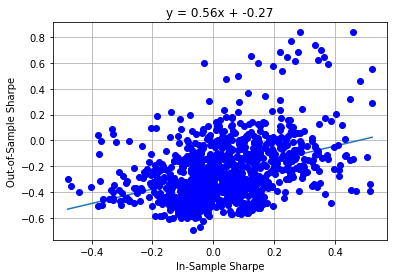

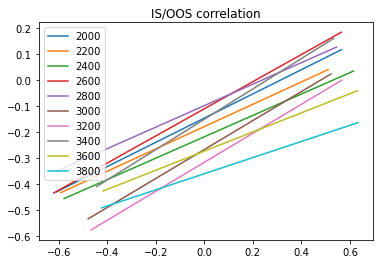

In [114]:
def linreg(x,y):
    m =  np.polyfit(x,y,1)
    xx = np.linspace(min(x),max(x),100)
    yy = np.polyval(m,xx)
    return xx,yy,m

def oos_testing(rets,cutoff,metric,plot_points=True):
    M_is = []; M_os = []
    for ret in rets:
        M_is.append(metric(ret,0,cutoff))
        M_os.append(metric(ret,cutoff,-1))
    #
        
    xx,yy,m = linreg(M_is,M_os)
    plt.plot(xx,yy,label=cutoff)
    if plot_points:
        plt.plot(M_is,M_os,'bo')
        plt.xlabel('In-Sample Sharpe')
        plt.ylabel('Out-of-Sample Sharpe')
        plt.title('y = %.2fx + %.2f'%(m[0],m[1]))
        plt.grid()
        
Sharpe = lambda ret,c1,c2: np.mean(ret[c1:c2])/np.std(portf_ret[c1:c2])*16
oos_testing(rets,3000,Sharpe)
plt.show()

for coff in range(2000,4000,200):
    oos_testing(rets,coff,Sharpe,plot_points=False)
    
plt.title('IS/OOS correlation')
plt.legend()
plt.show()
# good: XOM, ORCL
# bad: MSFT, AMZN, IBM

## Part 2
### Plotting the response surface

C:\Users\User\AppData\Local\Temp/ipykernel_2784/3481324655.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


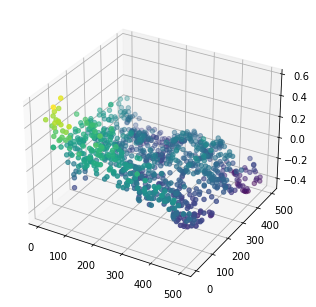

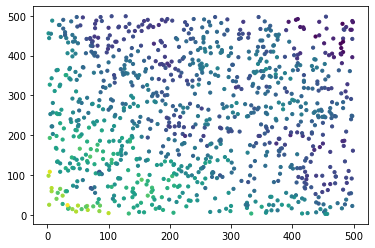

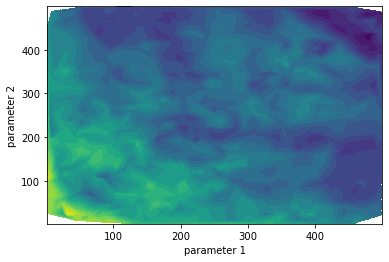

In [115]:
def plotter(res):
    '''
    Plots the results of the parameter sweep
    in 3D, scatter and contour plots.
    inputs:
        res: NxM results matrix
    '''
    
    x = np.array(res)[:,0]
    y = np.array(res)[:,1]
    z = np.array(res)[:,2]
    
    fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=z)
    plt.show()

    plt.scatter(x, y, c=z, s=10)
    plt.show()
    
    N = 300
    xi,yi = np.meshgrid(np.linspace(min(x),max(x),N),np.linspace(min(y),max(y),N))
    zi = griddata((x,y),z,(xi,yi),method='linear')
    plt.contourf(xi,yi,zi,20)
    plt.xlabel('parameter 1')
    plt.ylabel('parameter 2')
    
    return x,y,z
    
x,y,z = plotter(res)

### Finding the best parameter sets

In [116]:
import copy

In [117]:
def find_best_corr(x,y,z,rets,N_best,N_samples,cutoff):
    idx = np.argsort(z)[-N_best:]
    mat = np.corrcoef(np.array(rets)[idx,:cutoff])
    mat_sq = mat**2
    new_mat = copy.copy(mat_sq)
    new_idx = idx
    while new_mat.shape[0]>N_samples:
        col_sums = np.sum(new_mat,axis=0)
        to_del = np.argsort(col_sums)[-1]
        new_mat = np.delete(new_mat,to_del,0)
        new_mat = np.delete(new_mat,to_del,1)
        new_idx = np.delete(new_idx,to_del,0)
    return new_mat,new_idx,x[new_idx],y[new_idx]
    
cutoff = -2800
new_mat, new_idx, xnew, ynew = find_best_corr(x,y,z,rets,40,5,cutoff)

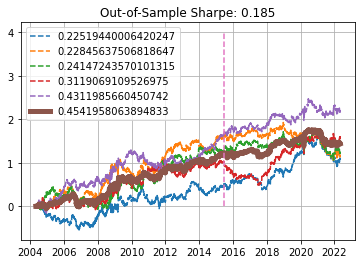

In [118]:
for i in new_idx:
    S = np.mean(rets[i])/np.std(rets[i])*16
    plt.plot(data.index[-len(rets[i]):],np.cumsum(rets[i]),'--',label=S)
       
portf = np.mean(np.array(rets)[new_idx],axis=0)
S_port = np.mean(portf)/np.std(portf)*16
S_oos = np.mean(portf[-cutoff:])/np.std(portf[-cutoff:])*16
combined = np.cumsum(np.mean(np.array(rets)[new_idx],axis=0))
plt.plot(data.index[-len(combined):],combined,lw=5,label=S_port)
plt.plot([data.index[-len(combined):][-cutoff]]*2,[0,4],'--')
plt.legend()
plt.title("Out-of-Sample Sharpe: %.3f"%S_oos)
plt.grid()